In [1]:
import requests
from bs4 import BeautifulSoup

user_agent = {'User-agent': 'Mozilla/5.0'}
              
url = 'https://en.wikipedia.org/w/index.php?title=List_of_Korean_dramas&'
page = requests.get(url, headers = user_agent)

soup = BeautifulSoup(page.content)

In [2]:
all_li = soup.find_all('li')

In [3]:
drama_elements = [element for element in all_li if element.find('i') is not None]
#print(drama_elements[:5]) #ensure first 5 elements are dramas
#print(drama_elements[-5:]) #ensure last 5 elements are dramas

In [4]:
import datetime
import re

dramas_data = []

for drama in drama_elements:
    link = drama.find('a')
    dramas_data.append({'titles':link.text, 'url':link.attrs['href'], 'start_year':None, 'end_year':None, 'status':None, 'parent':None})
    year = re.search(r'\((.*?)\)', drama.text).group(1)
    if ' ' in year: #if the contents contains ' ' which suggest sentences
        year = re.findall(r'\((.*?)\)', drama.text)[1] # take the second bracket instead
    if '–' in year:
        year = year.replace('–','-') # clean up dashes
        
    if '-' in year:
        years = year.split('-')
        
        dramas_data[-1]['start_year'] = int(years[0])
        
        if 'present' in years[1]:
            dramas_data[-1]['end_year'] = int(datetime.datetime.now().year)
            dramas_data[-1]['status'] = 'ongoing'
        elif len(years[1]) == 2:
            dramas_data[-1]['end_year'] = int(years[0][:2] + years[1])
            if dramas_data[-1]['end_year'] < dramas_data[-1]['start_year']:
                dramas_data[-1]['end_year'] += 100
            dramas_data[-1]['status'] = 'completed'
        else:
            dramas_data[-1]['end_year'] = int(years[1])
            dramas_data[-1]['status'] = 'completed'

    else:
        #if never split
        if year == 'cancelled':
            dramas_data[-1]['status'] = 'cancelled'
        elif year == 'TBA':
            dramas_data[-1]['status'] = 'tba'
        else:
            dramas_data[-1]['start_year'] = int(year)
            dramas_data[-1]['end_year'] = int(year)
            dramas_data[-1]['status'] = 'completed'

# add the parent url into child dramas data
for i, drama in enumerate(drama_elements):
    childs = drama.find('ul')
    if childs:
        for count in range(len(childs.find_all('li'))):
            dramas_data[i+count+1]['parent'] = dramas_data[i]['url']

print(dramas_data[300:320])

[{'titles': 'Did We Really Love?', 'url': '/wiki/Did_We_Really_Love%3F', 'start_year': 1999, 'end_year': 1999, 'status': 'completed', 'parent': None}, {'titles': 'Different Dreams', 'url': '/wiki/Different_Dreams', 'start_year': 2019, 'end_year': 2019, 'status': 'completed', 'parent': None}, {'titles': 'Dinner Mate', 'url': '/wiki/Dinner_Mate', 'start_year': 2020, 'end_year': 2020, 'status': 'completed', 'parent': None}, {'titles': 'Discovery of Love', 'url': '/wiki/Discovery_of_Love', 'start_year': 2014, 'end_year': 2014, 'status': 'completed', 'parent': None}, {'titles': 'Distorted', 'url': '/wiki/Distorted_(TV_series)', 'start_year': 2017, 'end_year': 2017, 'status': 'completed', 'parent': None}, {'titles': 'Divorce Attorney Shin', 'url': '/wiki/Divorce_Attorney_Shin', 'start_year': 2023, 'end_year': 2023, 'status': 'completed', 'parent': None}, {'titles': 'Divorce Lawyer in Love', 'url': '/wiki/Divorce_Lawyer_in_Love', 'start_year': 2015, 'end_year': 2015, 'status': 'completed', 'p

In [5]:
import pandas as pd
import numpy as np

dramas_df = pd.DataFrame(dramas_data)

dramas_df['start_year'] = pd.to_numeric(dramas_df['start_year']).astype('Int64')
dramas_df['end_year'] = pd.to_numeric(dramas_df['end_year']).astype('Int64')

display(dramas_df.info())
display(dramas_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   titles      1701 non-null   object
 1   url         1701 non-null   object
 2   start_year  1696 non-null   Int64 
 3   end_year    1696 non-null   Int64 
 4   status      1701 non-null   object
 5   parent      48 non-null     object
dtypes: Int64(2), object(4)
memory usage: 83.2+ KB


None

,titles,url,start_year,end_year,status,parent
0,100 Days My Prince,/wiki/100_Days_My_Prince,2018,2018,completed,None
1,12 Signs of Love,/wiki/12_Signs_of_Love,2012,2012,completed,None
2,12 Years Promise,/wiki/12_Years_Promise,2014,2014,completed,None
3,18 Again,/wiki/18_Again,2020,2020,completed,None
4,1st Republic,/wiki/1st_Republic_(TV_series),1981,1982,completed,None


In [6]:
# Calculate the frequency of each unique status value
print('----------drama status----------')
print(f"Total number of dramas: {dramas_df.shape[0]}")
print(f"Completed dramas :{(dramas_df['status'] == 'completed').sum()}, Frequency: {((dramas_df['status'] == 'completed').sum()/dramas_df.shape[0]):.4f}%")
print(f"TBA dramas :{(dramas_df['status'] == 'tba').sum()}, Frequency: {((dramas_df['status'] == 'tba').sum()/dramas_df.shape[0]):.4f}%")
print(f"Cancelled dramas :{(dramas_df['status'] == 'cancelled').sum()}, Frequency: {((dramas_df['status'] == 'cancelled').sum()/dramas_df.shape[0]):.4f}%")
print(f"Ongoing dramas :{(dramas_df['status'] == 'ongoing').sum()}, Frequency: {((dramas_df['status'] == 'ongoing').sum()/dramas_df.shape[0]):.4f}%")

# Use Pandas's methods to identify all dramas 
# (title, url, status, start_year, end_year) that have at least one 
# associated sub-drama
print('\n----------parent dramas----------')
print(f"Number of parent dramas: {dramas_df['parent'].nunique()}")

parent_dramas_df = pd.DataFrame()
for url in dramas_df['parent'].unique():
    if url:
        df = dramas_df[dramas_df['url']==url]
        parent_dramas_df = pd.concat([parent_dramas_df, df], ignore_index=True)
display(parent_dramas_df)

# Use Pandas's methods to identify all dramas 
# (title, url, status, start_year, end_year) that have at least 3 associated 
# sub-drama.
#for NoOfChild in dramas_df['parent'].value_counts():
#    if NoOfChild >= 3:
#        display(dramas_df)
print('----------parent dramas with 3 or more child----------')
Three_child_parent_df = pd.DataFrame()
url_counts = dramas_df['parent'].value_counts()
for url, c in url_counts.items():
    if c >= 3:
        df = parent_dramas_df[parent_dramas_df['url']==url]
        Three_child_parent_df = pd.concat([Three_child_parent_df, df], ignore_index=True)
display(Three_child_parent_df)

----------drama status----------
Total number of dramas: 1701
Completed dramas :1683, Frequency: 0.9894%
TBA dramas :4, Frequency: 0.0024%
Cancelled dramas :1, Frequency: 0.0006%
Ongoing dramas :13, Frequency: 0.0076%

----------parent dramas----------
Number of parent dramas: 10


,titles,url,start_year,end_year,status,parent
0,Drama City,/wiki/Drama_City,1984,2008,completed,None
1,Drama Special Series,/wiki/Drama_Special_Series,2010,2013,completed,None
2,Drama Stage,/wiki/Drama_Stage,2017,2024,ongoing,None
3,Endless Love Series,/wiki/Endless_Love_(2000_TV_series),2000,2006,completed,None
4,JTBC Drama Festa,/wiki/JTBC_Drama_Festa,2017,2024,ongoing,None
5,KBS Drama Special,/wiki/KBS_Drama_Special,2010,2024,ongoing,None
6,KBS TV Novel,/wiki/KBS_TV_Novel,1987,2018,completed,None
7,Reply Series,/wiki/Reply_(TV_series),2012,2016,completed,None
8,School Series,/wiki/School_(South_Korean_TV_series),1999,2024,ongoing,None
9,Three Color Fantasy,/wiki/Three_Color_Fantasy,2017,2017,completed,None


----------parent dramas with 3 or more child----------


,titles,url,start_year,end_year,status,parent
0,KBS TV Novel,/wiki/KBS_TV_Novel,1987,2018,completed,None
1,KBS Drama Special,/wiki/KBS_Drama_Special,2010,2024,ongoing,None
2,Drama Special Series,/wiki/Drama_Special_Series,2010,2013,completed,None
3,Endless Love Series,/wiki/Endless_Love_(2000_TV_series),2000,2006,completed,None
4,School Series,/wiki/School_(South_Korean_TV_series),1999,2024,ongoing,None
5,Drama Stage,/wiki/Drama_Stage,2017,2024,ongoing,None
6,Reply Series,/wiki/Reply_(TV_series),2012,2016,completed,None
7,Three Color Fantasy,/wiki/Three_Color_Fantasy,2017,2017,completed,None


C:\Users\user\AppData\Local\Temp\ipykernel_17092\905561173.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


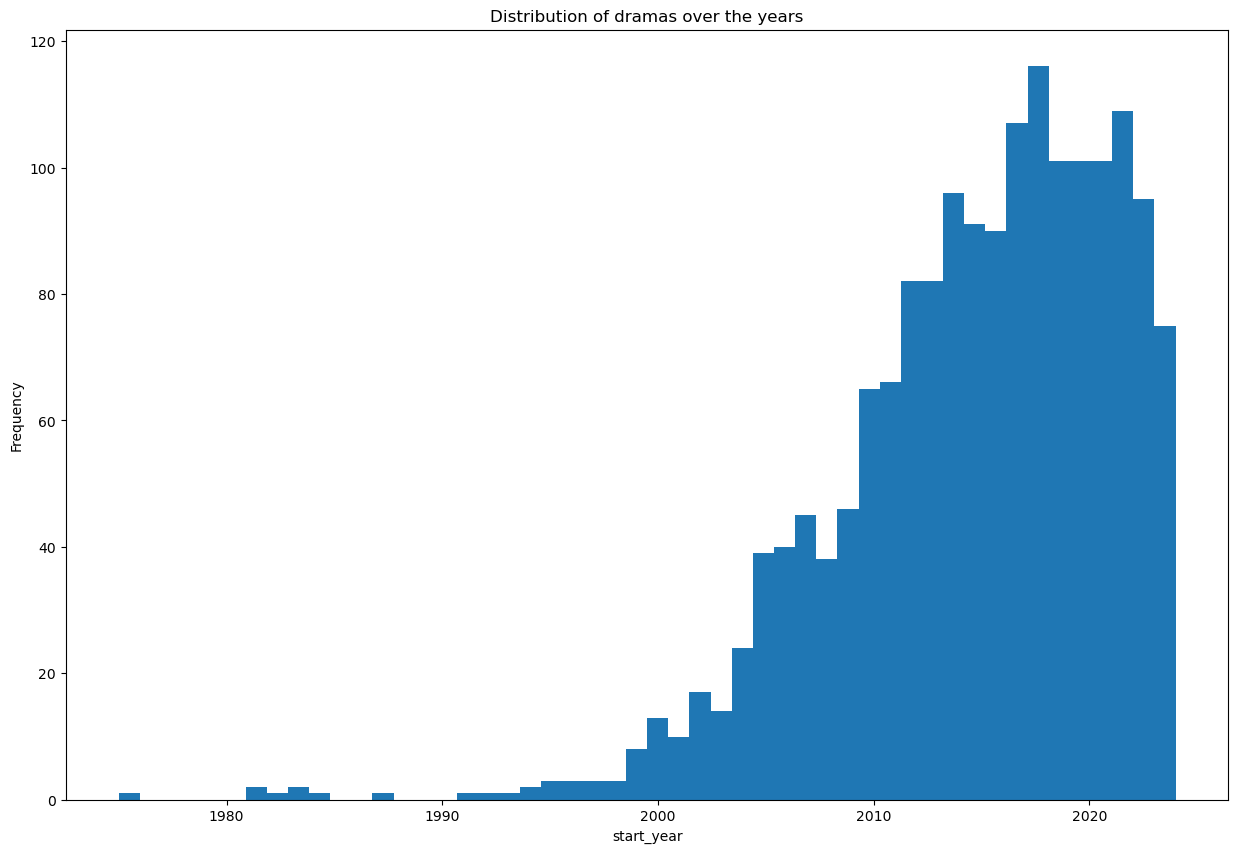

In [7]:
# Plot the number of dramas starting each year to identify trends over time.

%matplotlib inline
import matplotlib.pyplot as plt

dramas_df_with_start_year = dramas_df.dropna(subset=['start_year']).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
axes1 = fig.add_subplot(1,1,1)
axes1.hist(dramas_df_with_start_year['start_year'], bins=50)
axes1.set_xlabel('start_year')
axes1.set_ylabel('Frequency')
axes1.set_title('Distribution of dramas over the years')

fig.show()

In [8]:
# Calculates the broadcasting duration of each drama.
# If a drama is currently ongoing, consider the current year as the end of its duration.

dramas_df_with_start_year['duration'] = dramas_df_with_start_year['end_year']-dramas_df_with_start_year['start_year']
display(dramas_df_with_start_year)

# Determine the dramas with the longest and shortest durations.\

min_duration_dramas_df = dramas_df_with_start_year[dramas_df_with_start_year['duration'] == dramas_df_with_start_year['duration'].min()]
print('----------dramas with the shortest durations----------')
display(min_duration_dramas_df)

max_duration_dramas_df = dramas_df_with_start_year[dramas_df_with_start_year['duration'] == dramas_df_with_start_year['duration'].max()]
print('----------dramas with the longest duration----------')
display(max_duration_dramas_df)

# Calculate the average broadcasting duration of all dramas.

average_broadcasting_duration = dramas_df_with_start_year['duration'].mean()
print(f'The average broadcasting duration is {average_broadcasting_duration:.3f} years.')

# Detect duplicated dramas and eliminate the duplicates.

unique_dramas_df = dramas_df.drop_duplicates(keep='first').reset_index()

,titles,url,start_year,end_year,status,parent,duration
0,100 Days My Prince,/wiki/100_Days_My_Prince,2018,2018,completed,None,0
1,12 Signs of Love,/wiki/12_Signs_of_Love,2012,2012,completed,None,0
2,12 Years Promise,/wiki/12_Years_Promise,2014,2014,completed,None,0
3,18 Again,/wiki/18_Again,2020,2020,completed,None,0
4,1st Republic,/wiki/1st_Republic_(TV_series),1981,1982,completed,None,1
...,...,...,...,...,...,...,...
1691,Your Lady,/wiki/Your_Lady,2013,2013,completed,None,0
1692,Your Neighbor's Wife,/wiki/Your_Neighbor%27s_Wife,2013,2013,completed,None,0
1693,Youth of May,/wiki/Youth_of_May,2021,2021,completed,None,0
1694,Yumi's Cells,/wiki/Yumi%27s_Cells,2021,2022,completed,None,1


----------dramas with the shortest durations----------


,titles,url,start_year,end_year,status,parent,duration
0,100 Days My Prince,/wiki/100_Days_My_Prince,2018,2018,completed,None,0
1,12 Signs of Love,/wiki/12_Signs_of_Love,2012,2012,completed,None,0
2,12 Years Promise,/wiki/12_Years_Promise,2014,2014,completed,None,0
3,18 Again,/wiki/18_Again,2020,2020,completed,None,0
5,365: Repeat the Year,/wiki/365:_Repeat_the_Year,2020,2020,completed,None,0
...,...,...,...,...,...,...,...
1690,Your House Helper,/wiki/Your_House_Helper,2018,2018,completed,None,0
1691,Your Lady,/wiki/Your_Lady,2013,2013,completed,None,0
1692,Your Neighbor's Wife,/wiki/Your_Neighbor%27s_Wife,2013,2013,completed,None,0
1693,Youth of May,/wiki/Youth_of_May,2021,2021,completed,None,0


----------dramas with the longest duration----------


,titles,url,start_year,end_year,status,parent,duration
675,KBS TV Novel,/wiki/KBS_TV_Novel,1987,2018,completed,None,31


The average broadcasting duration is 0.350 years.


In [9]:
#Use BeautifulSoup to create a function named scrape_drama_details that 
#accepts a Wikipedia drama URL and retrieves details such as genres, main 
#actors/actresses, and the total number of episodes.

def scrape_drama_details(url):
    
    response = requests.get('https://en.wikipedia.org' + url)
    
    if response.status_code != 200:
        return 'page not found'
    soup = BeautifulSoup(response.text)
    
    infobox = soup.find('table', {'class':'infobox'})

    genres = []
    stars = []
    episodes = None
    
    if infobox == None:
        cast_head = soup.find('span', {'id':'Cast'})
        if cast_head:
            next_h2 = cast_head.find_next('h2')
            current = cast_head.find_next()
            a_tags = []
            while current and current != next_h2:
                if current.name == 'li':
                    # Find all <a> tags within the current <li>
                    a_tags += current.find_all('a', recursive=False)
                current = current.find_next()
            
            stars = [(a_tag.get_text().strip(), a_tag['href']) for a_tag in a_tags]
                
    
    if infobox:
        for items in infobox.find_all('tr'):
            header = items.find('th')
            data = items.find('td')
            links = items.find_all('a')

            if header and data:
                header_text = header.get_text().strip().lower()

                for link in links:
                    link_text = link.get_text().strip()
                    href = link.get('href')
                    if 'genre' in header_text:
                        if '[' not in link_text:
                            genres.append((link_text, href))
                    if 'starring' in header_text:
                        if '[' not in link_text:
                            stars.append((link_text,href))

                if 'episodes' in header_text:
                    episodes = re.sub(r'[\[\]]', '(', data.get_text(), flags=re.IGNORECASE)
                    episodes = re.sub(r'episodes?|no\.|part', 'Season', episodes, flags=re.IGNORECASE).strip()
                    episodes = re.sub(r':', ' – ', episodes).strip()
                    if episodes.isdigit():
                        episodes = int(episodes)
                    elif '+' in episodes:
                        episodes = sum(int(num) for num in re.findall(r'\d+', episodes))
                    elif '(' in episodes:
                        episodes = episodes.split('(')[0].strip()
                        if episodes.isdigit():
                            episodes = int(episodes)
                    elif episodes.lower().count('season') > 1:
                        total_episodes = 0
                        for part in episodes.lower().split('season'):
                            if '–' in part:
                                numbers = [int(num) for num in part.split('–') if num.strip().isdigit()][1]
                                total_episodes += int(numbers)
                            if total_episodes != 0:
                                episodes = total_episodes
                    elif 'season' in episodes.lower():
                        for part in episodes.lower().split('season'):
                            if part.strip().isdigit():
                                episodes = int(part.strip())

        return {'url':url, 'genres': genres, 'starrings': stars, 'episodes': episodes}

url = '/wiki/12_Years_Promise'
drama_details = scrape_drama_details(url)
print(f'12_Years_Promise drama details :\n{drama_details}')

url = '/wiki/100_Days_My_Prince'
drama_details = scrape_drama_details(url)
print(f'\n100_Days_My_Prince drama details :\n{drama_details}')

url = '/wiki/A_Good_Day_to_Be_a_Dog'
drama_details = scrape_drama_details(url)
print(f'\nA_Good_Day_to_Be_a_Dog drama details :\n{drama_details}')

12_Years_Promise drama details :
{'url': '/wiki/12_Years_Promise', 'genres': [('Romantic comedy', '/wiki/Romantic_comedy')], 'starrings': [('Lee So-yeon', '/wiki/Lee_So-yeon_(actress)'), ('Namkoong Min', '/wiki/Namkoong_Min'), ('Lee Tae-im', '/wiki/Lee_Tae-im'), ('Yoon So-hee', '/wiki/Yoon_So-hee'), ('Lee Won-keun', '/wiki/Lee_Won-keun'), ('Ryu Hyo-young', '/wiki/Ryu_Hyo-young')], 'episodes': 26}

100_Days_My_Prince drama details :
{'url': '/wiki/100_Days_My_Prince', 'genres': [('Historical', '/wiki/Sageuk'), ('Romantic comedy', '/wiki/Romantic_comedy')], 'starrings': [('Doh Kyung-soo', '/wiki/D.O._(entertainer)'), ('Nam Ji-hyun', '/wiki/Nam_Ji-hyun'), ('Jo Sung-ha', '/wiki/Jo_Sung-ha'), ('Jo Han-chul', '/wiki/Jo_Han-chul'), ('Kim Seon-ho', '/wiki/Kim_Seon-ho'), ('Han So-hee', '/wiki/Han_So-hee'), ('Kim Jae-young', '/wiki/Kim_Jae-young_(actor)')], 'episodes': 18}

A_Good_Day_to_Be_a_Dog drama details :
{'url': '/wiki/A_Good_Day_to_Be_a_Dog', 'genres': [('Romantic comedy', '/wiki/Romant

In [10]:
#Invoke the scrape_drama_details function to gather information for all drama URLs (obtained from step 1a))

import json

# takes about 4-5min to run
dramas_data = unique_dramas_df['url'].apply(scrape_drama_details)

In [11]:
dramas_data_list = dramas_data.tolist()
dramas_data_list = [data for data in dramas_data_list if data is not None]

In [12]:
# Present the details of the first five dramas

print('Details of first 5 dramas is :\n')
for row in dramas_data_list[:5]:
    print(row)
    print()

Details of first 5 dramas is :

{'url': '/wiki/100_Days_My_Prince', 'genres': [('Historical', '/wiki/Sageuk'), ('Romantic comedy', '/wiki/Romantic_comedy')], 'starrings': [('Doh Kyung-soo', '/wiki/D.O._(entertainer)'), ('Nam Ji-hyun', '/wiki/Nam_Ji-hyun'), ('Jo Sung-ha', '/wiki/Jo_Sung-ha'), ('Jo Han-chul', '/wiki/Jo_Han-chul'), ('Kim Seon-ho', '/wiki/Kim_Seon-ho'), ('Han So-hee', '/wiki/Han_So-hee'), ('Kim Jae-young', '/wiki/Kim_Jae-young_(actor)')], 'episodes': 18}

{'url': '/wiki/12_Signs_of_Love', 'genres': [('Romantic comedy', '/wiki/Romantic_comedy')], 'starrings': [('Yoon Jin-seo', '/wiki/Yoon_Jin-seo'), ('On Joo-wan', '/wiki/On_Joo-wan')], 'episodes': 16}

{'url': '/wiki/12_Years_Promise', 'genres': [('Romantic comedy', '/wiki/Romantic_comedy')], 'starrings': [('Lee So-yeon', '/wiki/Lee_So-yeon_(actress)'), ('Namkoong Min', '/wiki/Namkoong_Min'), ('Lee Tae-im', '/wiki/Lee_Tae-im'), ('Yoon So-hee', '/wiki/Yoon_So-hee'), ('Lee Won-keun', '/wiki/Lee_Won-keun'), ('Ryu Hyo-young', '

In [13]:
# Construct a new Pandas data frame from the Q2a) scraped drama details, 
# including drama_url, genre, and genre_url.

dramas_df = pd.DataFrame(dramas_data_list)
dramas_df.columns = ['url', 'genres', 'starrings', 'episodes']
dramas_df['episodes'] = dramas_df['episodes'].astype('Int64')
dramas_df = dramas_df.applymap(lambda x: None if isinstance(x, list) and not x else x)

In [14]:
dramas_genres_df = dramas_df.drop(columns=['starrings', 'episodes']).explode('genres').reset_index(drop=True)
dramas_genres_df['genre_url'] = dramas_genres_df['genres'].apply(lambda genre: genre[1] if type(genre) == tuple else None)
dramas_genres_df['genres'] = dramas_genres_df['genres'].apply(lambda genre: genre[0].lower() if type(genre) == tuple else None)

In [15]:
display(dramas_genres_df.head())
display(dramas_genres_df.info())
#display(dramas_genres_df['genres'].unique())
#print(dramas_genres_df['genres'].nunique())

,url,genres,genre_url
0,/wiki/100_Days_My_Prince,historical,/wiki/Sageuk
1,/wiki/100_Days_My_Prince,romantic comedy,/wiki/Romantic_comedy
2,/wiki/12_Signs_of_Love,romantic comedy,/wiki/Romantic_comedy
3,/wiki/12_Years_Promise,romantic comedy,/wiki/Romantic_comedy
4,/wiki/18_Again,romance,/wiki/Romance_film


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        3870 non-null   object
 1   genres     3741 non-null   object
 2   genre_url  3741 non-null   object
dtypes: object(3)
memory usage: 90.8+ KB


None

In [16]:
#Map genres into these common categories: 'comedy', 'historical', 
#'romance', 'fantasy', 'slice of life', 'crime', 'drama', 'speculative', 'action', 
#'thriller', 'horror', 'science', 'political', 'musical' and 'sport'

common_genres = ['comedy', 'historical', 'romance', 'fantasy', 'slice of life', 'crime', 'drama', 'speculative', 'action', 'thriller', 'horror', 'science', 'political', 'musical', 'sport']

def get_genre_group(genre):
    #if the genre has any word that is within the common_genres. e.g. 'historical fiction' will be in 'historical' genre
    for item in common_genres: 
        if genre:
            if item in genre:
                return item
            elif 'romantic' in genre:
                return 'romance'
            elif 'sageuk' in genre:
                return 'historical'
    return 'uncommon'


dramas_genres_df['genre_group'] = dramas_genres_df['genres'].apply(get_genre_group)
display(dramas_genres_df)

grouped = dramas_genres_df.groupby('genre_group')
#display(grouped.size())

,url,genres,genre_url,genre_group
0,/wiki/100_Days_My_Prince,historical,/wiki/Sageuk,historical
1,/wiki/100_Days_My_Prince,romantic comedy,/wiki/Romantic_comedy,comedy
2,/wiki/12_Signs_of_Love,romantic comedy,/wiki/Romantic_comedy,comedy
3,/wiki/12_Years_Promise,romantic comedy,/wiki/Romantic_comedy,comedy
4,/wiki/18_Again,romance,/wiki/Romance_film,romance
...,...,...,...,...
3865,/wiki/Yumi%27s_Cells,psychological drama,/wiki/Psychological_drama,drama
3866,/wiki/Yumi%27s_Cells,romantic drama,/wiki/Romantic_drama,romance
3867,/wiki/Zombie_Detective,comedy,/wiki/Comedy,comedy
3868,/wiki/Zombie_Detective,fantasy,/wiki/Fantasy_film,fantasy


C:\Users\user\AppData\Local\Temp\ipykernel_17092\1640933373.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


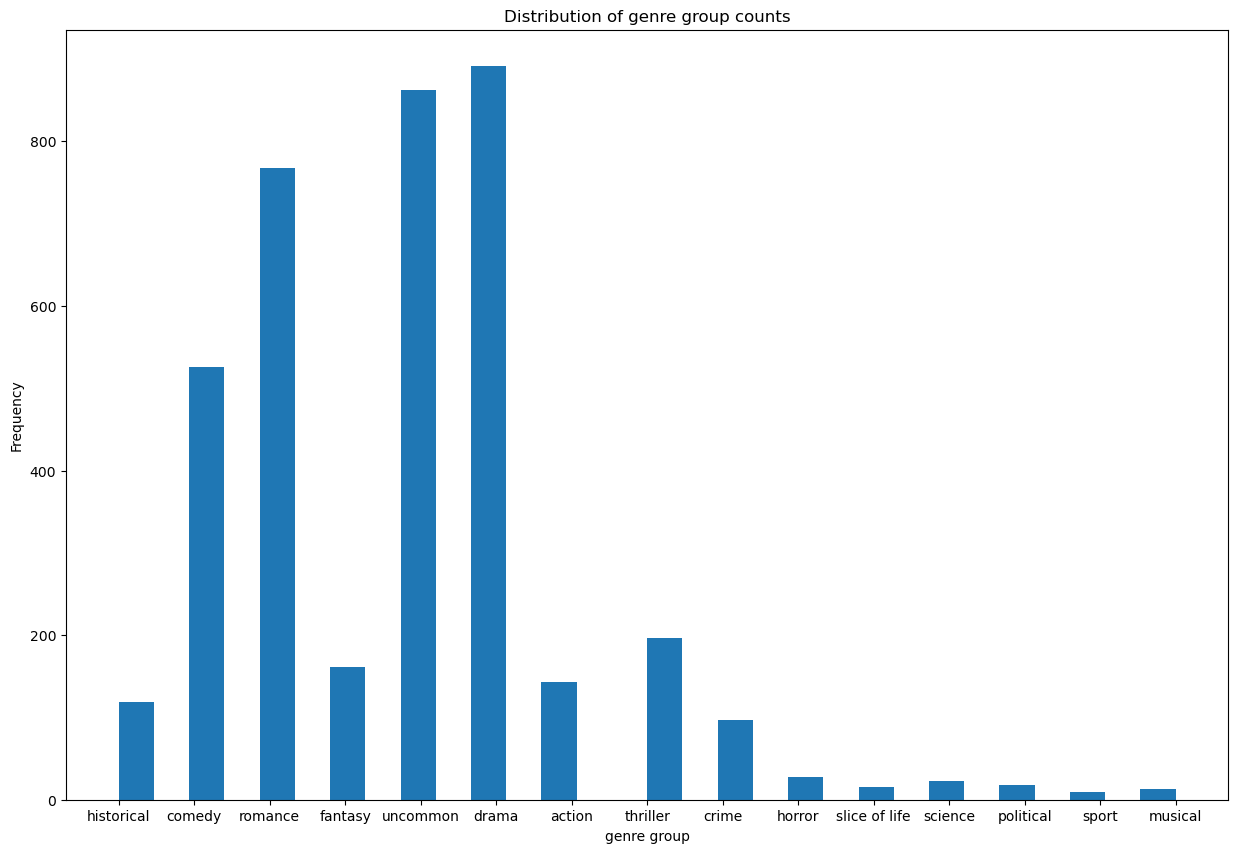

In [17]:
# visualize the count of dramas corresponding to each mapped genre.

fig = plt.figure(figsize=(15, 10))
axes2 = fig.add_subplot(1,1,1)
axes2.hist(dramas_genres_df['genre_group'], bins=30)
axes2.set_xlabel('genre group')
axes2.set_ylabel('Frequency')
axes2.set_title('Distribution of genre group counts')

fig.show()

In [18]:
# Identify all distinct (genre_url, genre) pairs from the data frame Q2b).

genres_df = dramas_genres_df.drop(columns=['url']).drop_duplicates().reset_index(drop=True)
genres_df = genres_df.dropna(subset=['genres']).reset_index(drop=True)
display(genres_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genres       284 non-null    object
 1   genre_url    284 non-null    object
 2   genre_group  284 non-null    object
dtypes: object(3)
memory usage: 6.8+ KB


None

In [19]:
#Use the requests and BeautifulSoup libraries to capture these redirected URLs into a new column redirected_genre_url.

#takes about 1-2min to run
def get_redirected_url(genre_url):
    if genre_url:
        if 'https:' not in genre_url:
            full_url = 'https://en.wikipedia.org' + genre_url
        else:
            full_url = genre_url
        response = requests.get(full_url) 
        soup = BeautifulSoup(response.text)
        have_redirect = re.search(r'"wgInternalRedirectTargetUrl":"(.*?)"', str(soup))

        if have_redirect:
            redirected_link = have_redirect.group(1)
            return redirected_link
        else:
            return genre_url
    
genres_df['redirected_genre_url'] = genres_df['genre_url'].apply(get_redirected_url)

In [20]:
#Show that the redirected URL of 
#'https://en.wikipedia.org/wiki/Romance_drama' is 
#'https://en.wikipedia.org/wiki/Romance_film#Romantic_drama'.

display(genres_df[genres_df['genre_url']=='/wiki/Romance_drama'])

,genres,genre_url,genre_group,redirected_genre_url
43,romance,/wiki/Romance_drama,romance,/wiki/Romance_film#Romantic_drama


In [21]:
#Ensure that the redirected genre URLs adhere to the 
#pattern https://en.wikipedia.org/wiki/{genre_name}#{anchor}, where 
#the anchor is not mandatory. Identify any redirected URLs that deviate from this 
#structure and modify them to align with the desired format

for i, row in genres_df.iterrows():
    if re.match(r'^.*#.*$', row['redirected_genre_url']): #check if the string has contents before and after the # symbol
        #print(f'matches the format {row["redirected_genre_url"]}')
        pass
    else:
        if '/wiki/' not in row['redirected_genre_url']:
            #these urls do not have a mandatory anchor
            print(f'does not match regex format or start with /wiki/ {row["redirected_genre_url"]}')
            split_string = row["redirected_genre_url"].split('&')
            for item in split_string:
                if 'title=' in item:
                    row["redirected_genre_url"] = '/wiki/' + item.split('=')[1]
            
        
# Conclusion: All the url follows the desired format

In [22]:
# Which redirected genre URLs include an anchor, denoted by #{anchor}?
print('These are the urls that include an anchor:')
for i, row in genres_df.iterrows():
    if re.match(r'^.*#.*$', row['redirected_genre_url']): #check if the string has contents before and after the # symbol
        #these urls have an anchor
        print(f'https://en.wikipedia.org{row["redirected_genre_url"]}')

These are the urls that include an anchor:
https://en.wikipedia.org/wiki/Children%27s_film#Family_films_versus_children's_films
https://en.wikipedia.org/wiki/Drama_(film_and_television)#Family_drama
https://en.wikipedia.org/wiki/Crime_fiction#Crime_thriller
https://en.wikipedia.org/wiki/Crime_film#Crime_drama
https://en.wikipedia.org/wiki/Drama_(film_and_television)#Drama_thriller
https://en.wikipedia.org/wiki/Action_film#Hybrid_genres
https://en.wikipedia.org/wiki/Young_adult_romance_literature#LGBTQ
https://en.wikipedia.org/wiki/Romance_film#Romantic_drama
https://en.wikipedia.org/wiki/Drama_(film_and_television)#Teen_drama
https://en.wikipedia.org/wiki/Drama_(film_and_television)#Fantasy_drama
https://en.wikipedia.org/wiki/Action_film#Hybrid_genres
https://en.wikipedia.org/wiki/Action_fiction#Genre_fiction
https://en.wikipedia.org/wiki/Romance_film#Romantic_drama
https://en.wikipedia.org/wiki/Drama_(film_and_television)#Teen_drama
https://en.wikipedia.org/wiki/Drama_(film_and_televi

In [23]:
#Note that certain genre URLs lead to the same redirected destinations. As a 
#result, a single redirected URL might be linked to various genres. Use your 
#discretion to modify their genres, ensuring that every redirected URL aligns 
#with only one genre.

#No longer in use, understood the question wrongly earlier.
# if the url has an anchor, i will take the anchor as the new genre, else i will use the genre_name as the new genre
#for i, row in genres_df.iterrows():
#    if re.match(r'^.*#.*$', row['redirected_genre_url']): #check if the string has contents before and after the # symbol
#        #these urls have an anchor
#        genres_df.loc[i, 'new_genres'] = row["redirected_genre_url"].split('#')[1]
#    else:
#        genres_df.loc[i, 'new_genres'] = row["redirected_genre_url"].split('#')[0][6:]

In [24]:
display(genres_df)

,genres,genre_url,genre_group,redirected_genre_url
0,historical,/wiki/Sageuk,historical,/wiki/Sageuk
1,romantic comedy,/wiki/Romantic_comedy,comedy,/wiki/Romantic_comedy
2,romance,/wiki/Romance_film,romance,/wiki/Romance_film
3,comedy,/wiki/Comedy,comedy,/wiki/Comedy
4,fantasy drama,/wiki/Fantasy_television,fantasy,/wiki/Fantasy_television
...,...,...,...,...
279,comedy,/wiki/Television_comedy,comedy,/wiki/Television_comedy
280,boys' love,/wiki/Yaoi,uncommon,/wiki/Yaoi
281,body swap,/wiki/Body_swap_appearances_in_media,uncommon,/wiki/Body_swap_appearances_in_media
282,web television,/wiki/Web_television,uncommon,/wiki/Streaming_television


In [25]:
#Eliminate any duplicate combinations of genre and its corresponding redirected URL

unique_genres_df = genres_df.drop_duplicates(subset=['redirected_genre_url'], keep='first').reset_index(drop=True)
display(unique_genres_df)

#for i, row in unique_genres_df.iterrows():
#    if row[0] != row[2]:
#        print(row[0], row[2], row[1], row[3])    
# Conclusion: all the redirected url aligns with only 1 genre.

,genres,genre_url,genre_group,redirected_genre_url
0,historical,/wiki/Sageuk,historical,/wiki/Sageuk
1,romantic comedy,/wiki/Romantic_comedy,comedy,/wiki/Romantic_comedy
2,romance,/wiki/Romance_film,romance,/wiki/Romance_film
3,comedy,/wiki/Comedy,comedy,/wiki/Comedy
4,fantasy drama,/wiki/Fantasy_television,fantasy,/wiki/Fantasy_television
...,...,...,...,...
165,musical,https://en.wiktionary.org/wiki/musical#Noun,musical,https://en.wiktionary.org/wiki/musical#Noun
166,comedy,/wiki/Television_comedy,comedy,/wiki/Television_comedy
167,body swap,/wiki/Body_swap_appearances_in_media,uncommon,/wiki/Body_swap_appearances_in_media
168,web television,/wiki/Web_television,uncommon,/wiki/Streaming_television


In [26]:
# Define a function called fetch_genre_description which utilizes 
# BeautifulSoup to extract textual content from a redirected genre URL.

def fetch_genre_description(url):
    if 'https:' not in url:
        full_url = 'https://en.wikipedia.org' + url
    else:
        full_url = url
    response = requests.get(full_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text)
        
        if re.match(r'^.*#.*$', full_url):
            anchor = url.split('#')[1]
            description_tag = soup.find('span', text=anchor.replace('_',' '))
        else:
            description_tag = soup.find('span', text='Description')
        
        if description_tag:
            p_tag = description_tag.find_next('p')
        else:
            p_tag = soup.find('p')
            index_c = 1
            while not p_tag.text.strip():
                p_tag = soup.find_all('p')[index_c] #use the next p tag, previous one is not relevant
                index_c += 1
        if p_tag:
            description = p_tag.text
            current = p_tag.find_next_sibling()
            while True:
                if current.name == 'p':
                    description += current.text
                    current = current.find_next_sibling()
                else:
                    break
            description = re.sub(r'\[\d+\]', '', description)
            description = description.replace('\n', '')
            return description
        else:
            return None
        
    else:
        return f"invalid url: {url}"
    
genre_url = "https://en.wikipedia.org/wiki/Romantic_comedy"
description = fetch_genre_description(genre_url)
print(f'\nDescription of {genre_url} is:')
print(description)


genre_url = "https://en.wikipedia.org/wiki/Children%27s_film#Family_films_versus_children's_films"
description = fetch_genre_description(genre_url)
print(f'\nDescription of {genre_url} is:')
print(description)


genre_url = "https://en.wikipedia.org/wiki/Drama_(film_and_television)"
description = fetch_genre_description(genre_url)
print(f'\nDescription of {genre_url} is:')
print(description)

# dont understand why the question ask to return None
genre_url = "https://en.wikipedia.org/wiki/Drama_(film_and_television)#Misidentified_categories"
description = fetch_genre_description(genre_url)
print(f'\nDescription of {genre_url} is:')
print(description)

C:\Users\user\AppData\Local\Temp\ipykernel_17092\603251573.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  description_tag = soup.find('span', text='Description')
C:\Users\user\AppData\Local\Temp\ipykernel_17092\603251573.py:15: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  description_tag = soup.find('span', text=anchor.replace('_',' '))



Description of https://en.wikipedia.org/wiki/Romantic_comedy is:
Romantic comedy (also known as romcom or rom-com) is a subgenre of comedy and romance fiction, focusing on lighthearted, humorous plot lines centered on romantic ideas, such as how true love is able to surmount most obstacles. In a typical romantic comedy, the two lovers tend to be young, likeable, and seemingly meant for each other, yet they are kept apart by some complicating circumstance (e.g., class differences, parental interference, a previous girlfriend or boyfriend) until, surmounting all obstacles, they are finally united. A fairy-tale-style happy ending is a typical feature.

Description of https://en.wikipedia.org/wiki/Children%27s_film#Family_films_versus_children's_films is:


Description of https://en.wikipedia.org/wiki/Drama_(film_and_television) is:
In film and television, drama is a category or genre of narrative fiction (or semi-fiction) intended to be more serious than humorous in tone. The drama of th

In [27]:
display(unique_genres_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   genres                170 non-null    object
 1   genre_url             170 non-null    object
 2   genre_group           170 non-null    object
 3   redirected_genre_url  170 non-null    object
dtypes: object(4)
memory usage: 5.4+ KB


None

In [28]:
#Call the fetch_genre_description function for each row in the data frame 
#and introduce a new column named genre_description filled with the 
#extracted genre descriptions.

#takes less than a min of run time
unique_genres_df['genre_description'] = unique_genres_df['redirected_genre_url'].apply(fetch_genre_description)

C:\Users\user\AppData\Local\Temp\ipykernel_17092\603251573.py:17: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  description_tag = soup.find('span', text='Description')
C:\Users\user\AppData\Local\Temp\ipykernel_17092\603251573.py:15: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  description_tag = soup.find('span', text=anchor.replace('_',' '))


In [29]:
#Delete entries that have a blank description

# I don't have any blank description.
# I don't understand why the question ask to give some description as None
unique_genres_df_desc = unique_genres_df.dropna(subset=['genre_description']).reset_index(drop=True)

In [30]:
display(unique_genres_df_desc)
display(dramas_genres_df)

,genres,genre_url,genre_group,redirected_genre_url,genre_description
0,historical,/wiki/Sageuk,historical,/wiki/Sageuk,Sageuk (Korean: 사극; Hanja: 史劇; listenⓘ) in Kor...
1,romantic comedy,/wiki/Romantic_comedy,comedy,/wiki/Romantic_comedy,Romantic comedy (also known as romcom or rom-c...
2,romance,/wiki/Romance_film,romance,/wiki/Romance_film,Romance films involve romantic love stories re...
3,comedy,/wiki/Comedy,comedy,/wiki/Comedy,Comedy is a genre of fiction that consists of ...
4,fantasy drama,/wiki/Fantasy_television,fantasy,/wiki/Fantasy_television,Fantasy television is a genre of television pr...
...,...,...,...,...,...
165,musical,https://en.wiktionary.org/wiki/musical#Noun,musical,https://en.wiktionary.org/wiki/musical#Noun,"From Middle English musical, from Old French [..."
166,comedy,/wiki/Television_comedy,comedy,/wiki/Television_comedy,Television comedy was/is a category of broadca...
167,body swap,/wiki/Body_swap_appearances_in_media,uncommon,/wiki/Body_swap_appearances_in_media,"Body swaps, first popularized in Western Anglo..."
168,web television,/wiki/Web_television,uncommon,/wiki/Streaming_television,Streaming television is the digital distributi...


,url,genres,genre_url,genre_group
0,/wiki/100_Days_My_Prince,historical,/wiki/Sageuk,historical
1,/wiki/100_Days_My_Prince,romantic comedy,/wiki/Romantic_comedy,comedy
2,/wiki/12_Signs_of_Love,romantic comedy,/wiki/Romantic_comedy,comedy
3,/wiki/12_Years_Promise,romantic comedy,/wiki/Romantic_comedy,comedy
4,/wiki/18_Again,romance,/wiki/Romance_film,romance
...,...,...,...,...
3865,/wiki/Yumi%27s_Cells,psychological drama,/wiki/Psychological_drama,drama
3866,/wiki/Yumi%27s_Cells,romantic drama,/wiki/Romantic_drama,romance
3867,/wiki/Zombie_Detective,comedy,/wiki/Comedy,comedy
3868,/wiki/Zombie_Detective,fantasy,/wiki/Fantasy_film,fantasy


In [33]:
# Utilize the CountVectorizer.fit_transform function from the sklearn 
# library to calculate the word frequency features for each genre, using the 
# processed description data from step Q2(d).

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)

def filter_english(text):
    english_pattern = r'\b[a-zA-Z]+\b'
    english_words = re.findall(english_pattern, text)
    english_text = ' '.join(english_words)
    return english_text

eng_genre_desc = unique_genres_df_desc['genre_description'].apply(filter_english)

vectorizer2 = CountVectorizer(stop_words=custom_stop_words)
X2 = vectorizer2.fit_transform(eng_genre_desc)
feature_names = vectorizer2.get_feature_names_out()

In [34]:
# Utilize the LatentDirichletAllocation algorithm from the sklearn library 
# to group word frequency features into 16 clusters, employing a random seed value of 42

from sklearn.decomposition import LatentDirichletAllocation
# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.

lda = LatentDirichletAllocation(n_components=16, random_state=42)
lda.fit(X2)
# get topics for some given samples:
topics = lda.transform(X2)

In [35]:
# Add the clusters computed by the LatentDirichletAllocation.transform method to the data frame from step Q2(c) under a new column named topic.

unique_genres_df_desc['topic'] = topics.argmax(axis=1)

In [36]:
display(unique_genres_df_desc)

,genres,genre_url,genre_group,redirected_genre_url,genre_description,topic
0,historical,/wiki/Sageuk,historical,/wiki/Sageuk,Sageuk (Korean: 사극; Hanja: 史劇; listenⓘ) in Kor...,9
1,romantic comedy,/wiki/Romantic_comedy,comedy,/wiki/Romantic_comedy,Romantic comedy (also known as romcom or rom-c...,3
2,romance,/wiki/Romance_film,romance,/wiki/Romance_film,Romance films involve romantic love stories re...,3
3,comedy,/wiki/Comedy,comedy,/wiki/Comedy,Comedy is a genre of fiction that consists of ...,7
4,fantasy drama,/wiki/Fantasy_television,fantasy,/wiki/Fantasy_television,Fantasy television is a genre of television pr...,15
...,...,...,...,...,...,...
165,musical,https://en.wiktionary.org/wiki/musical#Noun,musical,https://en.wiktionary.org/wiki/musical#Noun,"From Middle English musical, from Old French [...",8
166,comedy,/wiki/Television_comedy,comedy,/wiki/Television_comedy,Television comedy was/is a category of broadca...,9
167,body swap,/wiki/Body_swap_appearances_in_media,uncommon,/wiki/Body_swap_appearances_in_media,"Body swaps, first popularized in Western Anglo...",12
168,web television,/wiki/Web_television,uncommon,/wiki/Streaming_television,Streaming television is the digital distributi...,1


In [37]:
# Extract the top 10 words for each topic from the LDA model's components and then displays them in a data frame format

genres_group = ['comedy', 'historical', 'romance', 'fantasy', 'slice of life', 'crime', 'drama', 'speculative', 'action', 'thriller', 'horror', 'science', 'political', 'musical', 'sport', 'uncommon']

top_words_df = pd.DataFrame(columns=genres_group)

for i, topic_num in enumerate(lda.components_):
    top_words = topic_num.argsort()[:-11:-1]
    top_words = [feature_names[index] for index in top_words]
    top_words_df[genres_group[i]] = top_words

display(top_words_df)

,comedy,historical,romance,fantasy,slice of life,crime,drama,speculative,action,thriller,horror,science,political,musical,sport,uncommon
0,science,films,soap,love,film,comedy,films,romance,drama,historical,korean,genre,schools,fiction,fantasy,television
1,medicine,physical,opera,films,legal,war,film,food,television,television,family,comedy,school,romance,films,music
2,political,television,business,romantic,police,drama,genre,genre,series,series,history,horror,time,film,melodrama,fiction
3,human,film,television,film,musical,music,genres,characters,music,sageuk,fiction,legal,office,genre,friends,science
4,politics,disaster,radio,horror,films,genres,fiction,comedy,genre,crime,psychological,humor,mystery,crime,citation,time
5,humanism,reincarnation,term,sports,musicals,genre,action,plot,fiction,law,political,thriller,education,used,needed,shows
6,humanist,psychological,running,theatre,espionage,society,crime,films,tragedy,korean,narrative,age,slip,love,music,sports
7,used,religions,longest,genre,genre,revenge,thriller,film,sense,comedy,south,films,fiction,novels,cinema,reality
8,people,usually,making,focus,coming,variety,mystery,contemporary,film,criminal,youth,black,stories,noir,genre,events
9,art,feature,dramas,sport,apocalyptic,tragedy,super,young,web,films,historical,dark,body,novel,typically,sport


In [38]:
#Extract a single observation, such as insights regarding data cleansing or 
#preprocessing, or the categorization of genres based on word distributions.

all_words = top_words_df.values.flatten()
word_counts = pd.Series(all_words)
sorted_words = word_counts.value_counts().index.tolist()
print(f"The three most common words found in descending order are: '{sorted_words[0]}' followed by '{sorted_words[1]}' followed by '{sorted_words[2]}'.")

The three most common words found in descending order are: 'genre' followed by 'films' followed by 'film'.


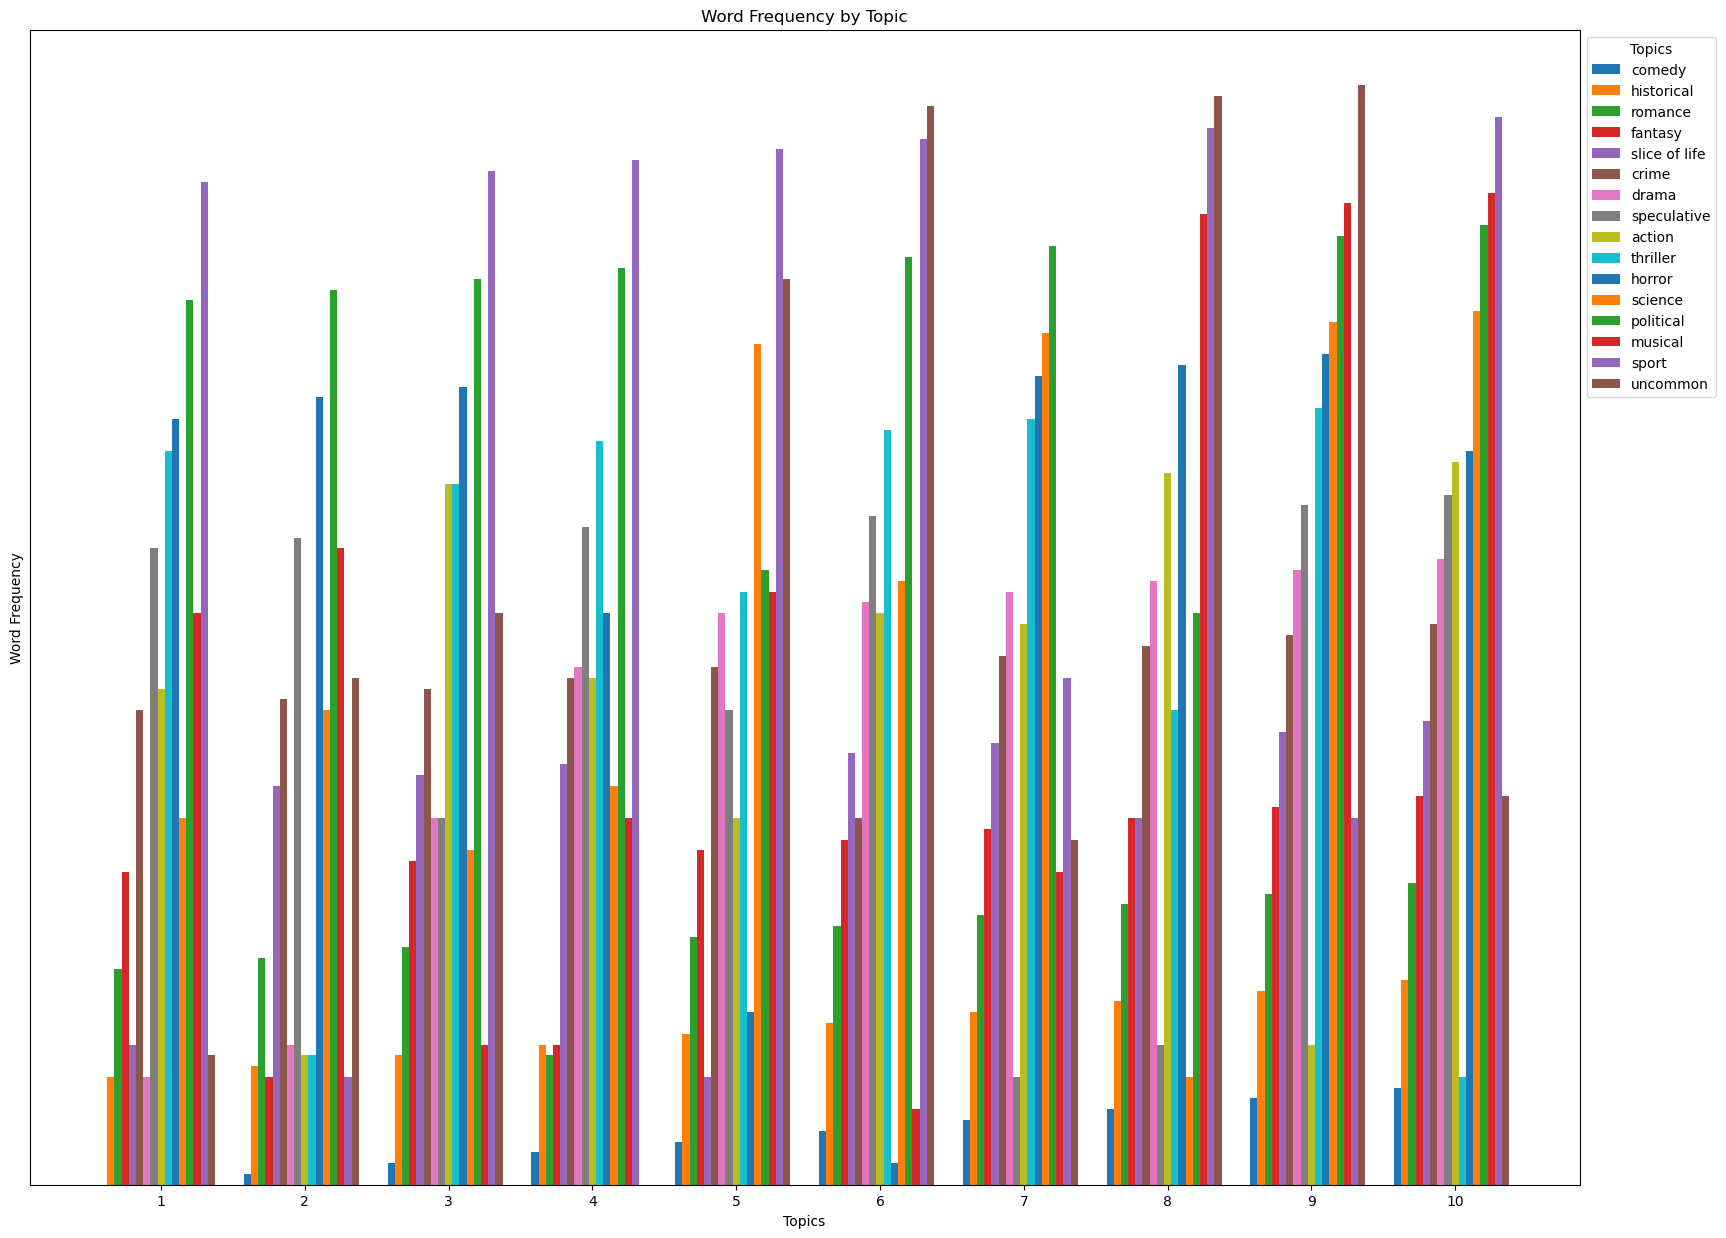

In [39]:
# Create a visual representation illustrating the correlations between the calculated topics 
# and genres. Extract three observations from the visualization.

top_words_df_transposed = top_words_df.T

plt.figure(figsize=(20, 15))

num_topics = len(top_words_df_transposed.columns)
num_words = len(top_words_df_transposed)

bar_width = 0.05

index = np.arange(num_topics)

for i, word in enumerate(top_words_df_transposed.index):
    plt.bar(index + i * bar_width, top_words_df_transposed.loc[word], bar_width, label=word)

plt.xlabel('Topics')
plt.ylabel('Word Frequency')
plt.title('Word Frequency by Topic')
plt.xticks(index + (bar_width * num_words) / 2, range(1, num_topics + 1))
plt.legend(title='Topics', loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks([])

plt.show()

In [40]:
#Read the dramas.csv file and store its contents in a dataframe called dramas_df

import pandas as pd

dramas_df = pd.read_csv('data/dramas.csv')

In [41]:
#Using the json library, read the contents of drama_details.txt and assign it to the drama_details variable

import json

with open('data/drama_details.txt', 'r') as file:
    drama_details = json.load(file)

In [42]:
# Integrate the episode count information from the drama_details variable into the dramas_df dataframe.


episodes_list = []
for drama in drama_details:
    if 'episodes' in drama:
        episode = drama['episodes']
        episodes_list.append(episode)
    else:
        episodes_list.append(pd.NA)

dramas_df['episodes'] = episodes_list
dramas_df[['start_year', 'end_year', 'broadcasting_duration', 'episodes']] = dramas_df[['start_year', 'end_year', 'broadcasting_duration', 'episodes']].astype('Int64')
display(dramas_df.info())
display(dramas_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   url                    1594 non-null   object
 1   title                  1594 non-null   object
 2   start_year             1592 non-null   Int64 
 3   end_year               1582 non-null   Int64 
 4   parent                 48 non-null     object
 5   status                 1594 non-null   object
 6   broadcasting_duration  1592 non-null   Int64 
 7   episodes               1541 non-null   Int64 
dtypes: Int64(4), object(4)
memory usage: 106.0+ KB


None

,url,title,start_year,end_year,parent,status,broadcasting_duration,episodes
0,/wiki/100_Days_My_Prince,100 Days My Prince,2018,2018,NaN,completed,0,16
1,/wiki/12_Signs_of_Love,12 Signs of Love,2012,2012,NaN,completed,0,16
2,/wiki/12_Years_Promise,12 Years Promise,2014,2014,NaN,completed,0,18
3,/wiki/18_Again,18 Again,2020,2020,NaN,completed,0,26
4,/wiki/1st_Republic_(TV_series),1st Republic,1981,1982,NaN,completed,1,24
...,...,...,...,...,...,...,...,...
1589,/wiki/Your_Neighbor%27s_Wife,Your Neighbor's Wife,2013,2013,NaN,completed,0,32
1590,/wiki/Youth_(TV_series),Youth,2021,2021,NaN,completed,0,<NA>
1591,/wiki/Youth_of_May,Youth of May,2021,2021,NaN,completed,0,24
1592,/wiki/Yumi%27s_Cells,Yumi's Cells,2021,2022,NaN,completed,1,12


In [43]:
# Based on the data in the drama_details variable, construct two new dataframes:
#1. starrings_df that contains columns 
#(starring_name, starring_url), 
#where starring_url represents the Wikipedia link of the actor or actress

# avoid using beautifulsoup. runtime too long
#import requests
#from bs4 import BeautifulSoup
#import re
#def get_redirected_url(genre_url):
#    if genre_url:
#        if 'https:' not in genre_url:
#            full_url = 'https://en.wikipedia.org' + genre_url
#        else:
#            full_url = genre_url
#        response = requests.get(full_url) 
#        soup = BeautifulSoup(response.text)
#        have_redirect = re.search(r'"wgInternalRedirectTargetUrl":"(.*?)"', str(soup))
#        if have_redirect:
#            redirected_link = have_redirect.group(1)
#            return redirected_link
#        else:
#            return genre_url

starrings_df = pd.DataFrame(columns=['starring_name', 'starring_url'])
        
stars_list = [] # contains a list of dicts
for drama in drama_details:
    stars = drama.get("starrings", [])
    for star in stars:
        starring_name, starring_url = star
        stars_list.append({'starring_name': starring_name, 'starring_url': starring_url})
starrings_df = pd.concat([starrings_df, pd.DataFrame(stars_list)], ignore_index=True)

starrings_df['starring_url'] = starrings_df['starring_url'].str.replace(',', '').str.replace(r'#.*$', '', regex=True)
starrings_df = starrings_df.drop_duplicates(subset='starring_url').reset_index(drop=True)
starrings_df.loc[starrings_df['starring_name'] == 'ko', 'starring_name'] = starrings_df[starrings_df['starring_name'] == 'ko']['starring_url'].str.split('/wiki/').str[1]
starrings_df['starring_url'] = starrings_df['starring_url'].apply(lambda x: '/wiki/' + x.split('title=')[1].split('&')[0] if 'title=' in x else x)
starrings_df = starrings_df.drop(starrings_df[starrings_df['starring_url'].str.startswith('#')].index).reset_index(drop=True)
#starrings_df['starring_url'] = starrings_df['starring_url'].apply(get_redirected_url)

display(starrings_df)

,starring_name,starring_url
0,Yoon Jin-seo,/wiki/Yoon_Jin-seo
1,On Joo-wan,/wiki/On_Joo-wan
2,Kim Ha-neul,/wiki/Kim_Ha-neul
3,Yoon Sang-hyun,/wiki/Yoon_Sang-hyun
4,Lee Do-hyun,/wiki/Lee_Do-hyun
...,...,...
1471,Kim Sung-joo,/wiki/Kim_Sung-joo_(entertainer)
1472,Han Da-min,/wiki/Han_Da-min
1473,Park Jung-min,/wiki/Park_Jung-min_(actor)
1474,Seo Eun-ah,/wiki/Seo_Eun-ah


In [44]:
#check for cleanliness of data

#non_wiki = starrings_df[starrings_df['starring_url'].str.startswith('/wiki/') == False]
#for i, row in non_wiki.iterrows():
#    print(row[1])

#duplicates_by_name = starrings_df[starrings_df.duplicated(subset='starring_name', keep=False)].sort_values(by='starring_name').reset_index(drop=True)
#display(duplicates_by_name['starring_name'].unique())
#for i, row in duplicates_by_name.iterrows():
#    print(row[0], row[1])

In [45]:
# Based on the data in the drama_details variable, construct two new dataframes:
# 2. castings_df that has columns (starring_url, drama_url), 
# indicating which actors or actresses starred in which dramas.

# for 1 drama, there can be many stars. There will be seperate rows for each star in a drama

castings_df = pd.DataFrame(columns=['starring_url', 'drama_url'])

data_list = []

for drama in drama_details:
    drama_url = drama["url"]
    stars = drama.get("starrings", [])
    for star in stars:
        data_list.append({'starring_url': star[1], 'drama_url': drama_url})
castings_df = pd.concat([castings_df, pd.DataFrame(data_list)], ignore_index=True)

castings_df['starring_url'] = castings_df['starring_url'].str.replace(',', '').str.replace(r'#.*$', '', regex=True)
castings_df['starring_url'] = castings_df['starring_url'].apply(lambda x: '/wiki/' + x.split('title=')[1].split('&')[0] if 'title=' in x else x)
castings_df = castings_df.drop(castings_df[(castings_df['starring_url'].str.startswith('#')) | (castings_df['starring_url'] == '')].index).reset_index(drop=True)

display(castings_df.head())

,starring_url,drama_url
0,/wiki/Yoon_Jin-seo,/wiki/12_Signs_of_Love
1,/wiki/On_Joo-wan,/wiki/12_Signs_of_Love
2,/wiki/Kim_Ha-neul,/wiki/18_Again
3,/wiki/Yoon_Sang-hyun,/wiki/18_Again
4,/wiki/Lee_Do-hyun,/wiki/18_Again


In [46]:
#check for both starring_url and drama_url that the data is clean
#non_wiki = castings_df[castings_df['drama_url'].str.startswith('/wiki') == False]
#for i, row in non_wiki.iterrows():
#    print(row[0], row[1])

In [47]:
#Design and save the dramas_df, starrings_df, and castings_df in a SQLite database.

import sqlite3

conn = sqlite3.connect("dramas_database.db")

dramas_df.to_sql("dramas", conn, if_exists="replace", index=False)
starrings_df.to_sql("starrings", conn, if_exists="replace", index=False)
castings_df.to_sql("castings", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

In [48]:
# Which actor or actress has starred in the most number of dramas? (Only one actor / actress is needed.) Address this inquiry by:
# 1. The sqlite3 library.

conn = sqlite3.connect("dramas_database.db")
cursor = conn.cursor()
cursor.execute("SELECT starring_url, COUNT(starring_url) AS count FROM castings GROUP BY starring_url ORDER BY count DESC LIMIT 1")
result = cursor.fetchone()
conn.close()

if result:
    starring_url, count = result
    star = starring_url[6:].replace('_',' ')
    print(f"The actor or actress that starred in the most number of dramas is {star} with {count} dramas.")

The actor or actress that starred in the most number of dramas is Jang Hyuk with 20 dramas.


In [49]:
# Which actor or actress has starred in the most number of dramas? (Only one actor / actress is needed.) Address this inquiry by:
# 2. The SQLAlchemy library.

from sqlalchemy import create_engine, select, func, Table, MetaData

engine = create_engine('sqlite:///dramas_database.db')
castings = Table('castings', MetaData(), autoload_with=engine)

conn = engine.connect()
result = conn.execute(select([castings.c.starring_url, func.count().label('count')]).group_by(castings.c.starring_url).order_by(func.count().desc()).limit(1)).fetchone()
conn.close()

if result:
    starring_url, count = result
    star = starring_url[6:].replace('_',' ')
    print(f"The actor or actress that starred in the most number of dramas is {star} with {count} dramas.")

The actor or actress that starred in the most number of dramas is Jang Hyuk with 20 dramas.


In [50]:
display(dramas_df.head())
display(castings_df.head())

,url,title,start_year,end_year,parent,status,broadcasting_duration,episodes
0,/wiki/100_Days_My_Prince,100 Days My Prince,2018,2018,NaN,completed,0,16
1,/wiki/12_Signs_of_Love,12 Signs of Love,2012,2012,NaN,completed,0,16
2,/wiki/12_Years_Promise,12 Years Promise,2014,2014,NaN,completed,0,18
3,/wiki/18_Again,18 Again,2020,2020,NaN,completed,0,26
4,/wiki/1st_Republic_(TV_series),1st Republic,1981,1982,NaN,completed,1,24


,starring_url,drama_url
0,/wiki/Yoon_Jin-seo,/wiki/12_Signs_of_Love
1,/wiki/On_Joo-wan,/wiki/12_Signs_of_Love
2,/wiki/Kim_Ha-neul,/wiki/18_Again
3,/wiki/Yoon_Sang-hyun,/wiki/18_Again
4,/wiki/Lee_Do-hyun,/wiki/18_Again


In [51]:
# What is the number of actors or actresses who took part in several dramas that aired 
# simultaneously, having overlapping broadcast periods end year)? Address this inquiry 
# by applying:
# 1. The sqlite3 library.

conn = sqlite3.connect("dramas_database.db")

cursor = conn.cursor()

sql_query3 = ("""
SELECT
  castings.starring_url,
  castings.drama_url AS individual_drama,
  dramas.start_year,
  dramas.end_year
FROM castings
JOIN dramas ON castings.drama_url = dramas.url
WHERE castings.starring_url IN (
  SELECT starring_url
  FROM castings
  GROUP BY starring_url
  HAVING COUNT(starring_url) > 1
)
AND (dramas.end_year - dramas.start_year) >= 1
ORDER BY castings.starring_url, individual_drama;
""")


cursor.execute(sql_query3)
results = cursor.fetchall()
conn.close()

print('Actors or actresses with overlapping dramas:\n')

#remove duplicates using python
actor_counts = {}
for result in results:
    if result[0] in actor_counts:
        actor_counts[result[0]] += 1
    else:
        actor_counts[result[0]] = 1
new_results = [result for result in results if actor_counts[result[0]] > 1]
new_results = [list(t) for t in new_results]

#get overlap data using python
actor_data = {}
for entry in new_results:
    actor_url, drama_url, start_year, end_year = entry
    if actor_url not in actor_data:
        actor_data[actor_url] = []

    actor_data[actor_url].append((drama_url, start_year, end_year))
    
processed_pairs = set()
for actor_url, entries in actor_data.items():
    for i, (drama_url, start_year, end_year) in enumerate(entries):
        for j, (other_drama_url, other_start_year, other_end_year) in enumerate(entries):
            if i != j and (start_year < other_end_year and end_year > other_start_year):
                pair = (min(drama_url, other_drama_url), max(drama_url, other_drama_url))
                if pair not in processed_pairs:
                    star = actor_url[6:].replace('_', ' ')
                    print(f'Overlap found for actor/actress: {star}')
                    print(f'Drama 1: {drama_url} ({start_year} - {end_year})')
                    print(f'Drama 2: {other_drama_url} ({other_start_year} - {other_end_year})\n')
                    processed_pairs.add(pair)

Actors or actresses with overlapping dramas:

Overlap found for actor/actress: Ahn Nae-sang
Drama 1: /wiki/High_Kick:_Revenge_of_the_Short_Legged (2011 - 2012)
Drama 2: /wiki/Quiz_of_God (2010 - 2019)

Overlap found for actor/actress: Choi Jung-woo
Drama 1: /wiki/Dr._Frost_(TV_series) (2014 - 2015)
Drama 2: /wiki/Quiz_of_God (2010 - 2019)

Overlap found for actor/actress: Go Ara
Drama 1: /wiki/Sharp_(TV_series) (2003 - 2007)
Drama 2: /wiki/Snow_Flower_(TV_series) (2006 - 2007)

Overlap found for actor/actress: Jang Hyuk
Drama 1: /wiki/Money_Flower (2017 - 2018)
Drama 2: /wiki/Voice_(TV_series) (2017 - 2021)

Overlap found for actor/actress: Jeong Yu-mi (actress born 1984)
Drama 1: /wiki/Partners_for_Justice (2018 - 2019)
Drama 2: /wiki/Priest_(TV_series) (2018 - 2019)

Overlap found for actor/actress: Kim Ji-won (actress)
Drama 1: /wiki/High_Kick:_Revenge_of_the_Short_Legged (2011 - 2012)
Drama 2: /wiki/What%27s_Up_(TV_series) (2011 - 2012)

Overlap found for actor/actress: Lee Min-ho


In [52]:
# What is the number of actors or actresses who took part in several dramas that aired 
# simultaneously, having overlapping broadcast periods end year)? Address this inquiry 
# by applying:
# 2. The SQLAlchemy library.

from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import and_, func

Base = declarative_base()

class Casting(Base):
    __tablename__ = 'castings'

    id = Column(Integer, primary_key=True)
    starring_url = Column(String)
    drama_url = Column(String)

class Drama(Base):
    __tablename__ = 'dramas'

    id = Column(Integer, primary_key=True)
    url = Column(String)
    start_year = Column(Integer)
    end_year = Column(Integer)

engine = create_engine("sqlite:///dramas_database.db")

Session = sessionmaker(bind=engine)
session = Session()

query = session.query(
    Casting.starring_url,
    Casting.drama_url.label('drama'),
    Drama.start_year,
    Drama.end_year
).join(
    Drama,
    Drama.url == Casting.drama_url
).filter(
    Casting.starring_url.in_(
        session.query(Casting.starring_url)
        .group_by(Casting.starring_url)
        .having(func.count(Casting.starring_url) > 1)
    ),
    (Drama.end_year - Drama.start_year) >= 1
).order_by(
    Casting.starring_url,
    'drama'
)
results = query.all()
session.close()

print('Actors or actresses with overlapping dramas:\n')

#remove duplicates using python
actor_counts = {}
for result in results:
    if result[0] in actor_counts:
        actor_counts[result[0]] += 1
    else:
        actor_counts[result[0]] = 1
new_results = [result for result in results if actor_counts[result[0]] > 1]
new_results = [list(t) for t in new_results]

#get overlap data using python
actor_data = {}
for entry in new_results:
    actor_url, drama_url, start_year, end_year = entry
    if actor_url not in actor_data:
        actor_data[actor_url] = []

    actor_data[actor_url].append((drama_url, start_year, end_year))

    
processed_pairs = set()
for actor_url, entries in actor_data.items():
    for i, (drama_url, start_year, end_year) in enumerate(entries):
        for j, (other_drama_url, other_start_year, other_end_year) in enumerate(entries):
            if i != j and (start_year < other_end_year and end_year > other_start_year):
                pair = (min(drama_url, other_drama_url), max(drama_url, other_drama_url))
                if pair not in processed_pairs:
                    star = actor_url[6:].replace('_', ' ')
                    print(f'Overlap found for actor/actress: {star}')
                    print(f'Drama 1: {drama_url} ({start_year} - {end_year})')
                    print(f'Drama 2: {other_drama_url} ({other_start_year} - {other_end_year})\n')
                    processed_pairs.add(pair)

Actors or actresses with overlapping dramas:

Overlap found for actor/actress: Ahn Nae-sang
Drama 1: /wiki/High_Kick:_Revenge_of_the_Short_Legged (2011 - 2012)
Drama 2: /wiki/Quiz_of_God (2010 - 2019)

Overlap found for actor/actress: Choi Jung-woo
Drama 1: /wiki/Dr._Frost_(TV_series) (2014 - 2015)
Drama 2: /wiki/Quiz_of_God (2010 - 2019)

Overlap found for actor/actress: Go Ara
Drama 1: /wiki/Sharp_(TV_series) (2003 - 2007)
Drama 2: /wiki/Snow_Flower_(TV_series) (2006 - 2007)

Overlap found for actor/actress: Jang Hyuk
Drama 1: /wiki/Money_Flower (2017 - 2018)
Drama 2: /wiki/Voice_(TV_series) (2017 - 2021)

Overlap found for actor/actress: Jeong Yu-mi (actress born 1984)
Drama 1: /wiki/Partners_for_Justice (2018 - 2019)
Drama 2: /wiki/Priest_(TV_series) (2018 - 2019)

Overlap found for actor/actress: Kim Ji-won (actress)
Drama 1: /wiki/High_Kick:_Revenge_of_the_Short_Legged (2011 - 2012)
Drama 2: /wiki/What%27s_Up_(TV_series) (2011 - 2012)

Overlap found for actor/actress: Lee Min-ho


In [53]:
#Which pairs of actors or actresses have appeared together in the most dramas? (Provide 
#ALL pairs that share the top spot for co-starring in number of dramas.)

conn = sqlite3.connect("dramas_database.db")

cursor = conn.cursor()

sql_query3 = ("""
WITH pairs AS (
  SELECT
    c1.starring_url AS actor1,
    c2.starring_url AS actor2,
    COUNT(*) AS count
  FROM
    castings c1
    JOIN castings c2 ON c1.drama_url = c2.drama_url AND c1.starring_url < c2.starring_url
  GROUP BY
    c1.starring_url, c2.starring_url
)

SELECT actor1, actor2, count
FROM pairs
WHERE count = (SELECT MAX(count) FROM pairs);
""")


cursor.execute(sql_query3)
results = cursor.fetchall()
conn.close()

for result in results:
    print(f"The pair {result[0][6:].replace('_', ' ')} and {result[1][6:].replace('_', ' ')} starred in the most dramas together of {result[2]} dramas")

The pair Go Doo-shim and Ha Seok-jin starred in the most dramas together of 3 dramas
The pair Jang Hyuk and Lee Da-hae starred in the most dramas together of 3 dramas
The pair Ji Jin-hee and Kim Hyun-joo starred in the most dramas together of 3 dramas


In [54]:
#Which actors/actresses have participated in the highest number of episodes?

conn = sqlite3.connect("dramas_database.db")

cursor = conn.cursor()

sql_query3 = ("""
SELECT
  castings.starring_url,
  SUM(dramas.episodes) AS total_episodes
FROM
  castings
  JOIN dramas ON castings.drama_url = dramas.url
GROUP BY
  castings.starring_url
ORDER BY
  total_episodes DESC
LIMIT 1;
""")


cursor.execute(sql_query3)
results = cursor.fetchall()
conn.close()

for result in results:
    print(f"The actor/actress {result[0][6:].replace('_', ' ')} starred in the most number of episodes of {result[1]} episodes")

The actor/actress Yoon Shi-yoon starred in the most number of episodes of 2784 episodes
